<a href="https://colab.research.google.com/github/bendavidsteel/trade-democratization/blob/master/trade_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams

rcParams['figure.figsize'] = 12, 6

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In this project we will be linking the [V-Dem dataset](https://www.v-dem.net/en) and the [CEPII Trade History dataset](http://www.cepii.fr/cepii/en/bdd_modele/bdd.asp) into a time series graph dataset, in an attempt to investigate how bilateral trade affects the democratization of nations over time.

In [ ]:
dataset_path = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization', 'dataset')
# here we load the democracy indices from the V-Dem dataset
vdem_nodes = pd.read_csv(os.path.join(dataset_path, "V-Dem-CY-Core-v10.csv"))
vdem_nodes.head()

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,codingstart_contemp,codingend_contemp,codingstart_hist,codingend_hist,gapstart1,gapstart2,gapstart3,gapend1,gapend2,gapend3,COWcode,v2x_polyarchy,v2x_polyarchy_codelow,v2x_polyarchy_codehigh,v2x_polyarchy_sd,v2x_libdem,v2x_libdem_codelow,v2x_libdem_codehigh,v2x_libdem_sd,v2x_partipdem,v2x_partipdem_codelow,v2x_partipdem_codehigh,v2x_partipdem_sd,v2x_delibdem,v2x_delibdem_codelow,v2x_delibdem_codehigh,v2x_delibdem_sd,v2x_egaldem,v2x_egaldem_codelow,v2x_egaldem_codehigh,...,v2x_EDcomp_thick,v2x_EDcomp_thick_codelow,v2x_EDcomp_thick_codehigh,v2x_EDcomp_thick_sd,v2x_freexp,v2x_freexp_codelow,v2x_freexp_codehigh,v2x_freexp_sd,v2x_hosabort,v2x_hosinter,v2x_legabort,v2xcl_disc,v2xcl_disc_codelow,v2xcl_disc_codehigh,v2xcl_disc_sd,v2xcl_dmove,v2xcl_dmove_codelow,v2xcl_dmove_codehigh,v2xcl_dmove_sd,v2xcl_slave,v2xcl_slave_codelow,v2xcl_slave_codehigh,v2xcl_slave_sd,v2xel_elecparl,v2xel_elecpres,v2xex_elecleg,v2xlg_leginter,v2xme_altinf,v2xme_altinf_codelow,v2xme_altinf_codehigh,v2xme_altinf_sd,v2xps_party,v2xps_party_codelow,v2xps_party_codehigh,v2x_divparctrl,v2x_feduni,v2xca_academ,v2xca_academ_codelow,v2xca_academ_codehigh,v2xca_academ_sd
0,Mexico,MEX,3,1789,1789-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.043,0.029,0.055,0.013,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,Mexico,MEX,3,1790,1790-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,Mexico,MEX,3,1791,1791-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,Mexico,MEX,3,1792,1792-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,Mexico,MEX,3,1793,1793-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
tradhist_gdppop = pd.read_excel(os.path.join(dataset_path, "TRADHIST_GDP_POP.xlsx"))
tradhist_gdppop.head()

,iso,year,GDP,SOURCE_GDP,POP,SOURCE_POP,SOURCE_SH_PRIM,SOURCE_SH_SECD,SH_PRIM,SH_SECD
0,MMR,1827,NaN,NaN,3605.399902,MADDISON_IPO,NaN,NaN,NaN,NaN
1,SOM,1827,NaN,NaN,1077.427124,MADDISON_IPO,NaN,NaN,NaN,NaN
2,ADEN,1827,NaN,NaN,2627.580078,MADDISON_IPO,NaN,NaN,NaN,NaN
3,MOZ,1827,NaN,NaN,2319.700684,MADDISON_IPO,NaN,NaN,NaN,NaN
4,PRI,1827,NaN,NaN,305.633331,MADDISON_IPO,NaN,NaN,NaN,NaN


In [ ]:
# now we load the time invariant bilateral data from the CEPII TradHist dataset
tradhist_timeinvar = pd.read_excel(os.path.join(dataset_path, "TRADHIST_GRAVITY_BILATERAL_TIME_INVARIANT.xlsx"))
tradhist_timeinvar.head()

,iso_o,iso_d,Distw,Dist_coord,Evercol,Comlang,Contig
0,2SICIL,AUTHUN,NaN,837.066180,0,0,0
1,2SICIL,BEL,NaN,1349.682430,0,0,0
2,2SICIL,CHL,NaN,11978.672481,0,0,0
3,2SICIL,ESP,NaN,1514.852764,0,0,0
4,2SICIL,FRA,NaN,1291.794085,0,0,0


In [ ]:
# then load the three files that constitute the bilateral historical non trade related data such as distances between countries and colonial status
tradhist_timevar_frames = []
for idx in range(1, 4):
    tradhist_timevar_frames.append(pd.read_excel(os.path.join(dataset_path, "TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))))
tradhist_timevar = pd.concat(tradhist_timevar_frames)
tradhist_timevar.head()

,iso_o,iso_d,year,SeaDist_SHRT,SeaDist_2CST,Curcol,Metro,Colo
0,2SICIL,AUTHUN,1838,1790.884033,1790.884033,0,NaN,NaN
1,2SICIL,BEL,1834,4463.319824,4463.319824,0,NaN,NaN
2,2SICIL,BEL,1835,4463.319824,4463.319824,0,NaN,NaN
3,2SICIL,BEL,1836,4463.319824,4463.319824,0,NaN,NaN
4,2SICIL,BEL,1837,4463.319824,4463.319824,0,NaN,NaN


In [ ]:
tradhist_bitrade_frames = []
for idx in range(1, 4):
    tradhist_bitrade_frames.append(pd.read_excel(os.path.join(dataset_path, "TRADHIST_BITRADE_BITARIFF_{}.xlsx".format(idx))))
tradhist_bitrade = pd.concat(tradhist_bitrade_frames)
tradhist_bitrade.head()

,iso_o,iso_d,year,FLOW,FLOW_0,SOURCE_TF,BITARIFF
0,2SICIL,AUTHUN,1838,492920.687500,NaN,RIC_IP,NaN
1,2SICIL,BEL,1834,38164.500000,NaN,RIC_IP,NaN
2,2SICIL,BEL,1835,30052.339844,NaN,RIC_IP,NaN
3,2SICIL,BEL,1836,44906.539062,NaN,RIC_IP,NaN
4,2SICIL,BEL,1837,33957.269531,NaN,RIC_IP,NaN


Previous studies how shown that geographical closeness and colonizer/colony status affects the diffusion of democracy. It seems likely following from this that trade would result in some democratization diffusion effect also.

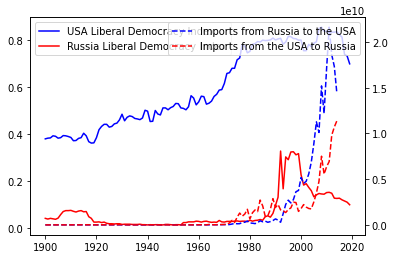

In [ ]:
# TradHist dataset has data for USSR separate than from Russia
# USA : USA
# Russia: RUS, USSR (VDem uses RUS only, TradHist uses RUS and USSR)
colours = ['r', 'b']

# get high level indicators of democracy
ctry_demind = {}
ctry_demind["USA"] = vdem_nodes[(vdem_nodes['country_text_id'] == "USA") & (vdem_nodes['year'] >= vdem_nodes['codingstart_contemp'])][['year', 'v2x_libdem']]
ctry_demind["RUS"] = vdem_nodes[(vdem_nodes['country_text_id'] == "RUS") & (vdem_nodes['year'] >= vdem_nodes['codingstart_contemp'])][['year', 'v2x_libdem']]


# get imports of one country from the other
ctry_trade = {}
ctry_trade["USA"] = tradhist_bitrade[((tradhist_bitrade['iso_o'] == "RUS") | (tradhist_bitrade['iso_o'] == "USSR"))
                                     & (tradhist_bitrade['iso_d'] == "USA") 
                                     & (tradhist_bitrade['year'] >= 1900)][['year', 'FLOW']].sort_values(by=['year'])
ctry_trade["RUS"] = tradhist_bitrade[(tradhist_bitrade['iso_o'] == "USA")
                                     & ((tradhist_bitrade['iso_d'] == "RUS") | (tradhist_bitrade['iso_d'] == "USSR"))
                                     & (tradhist_bitrade['year'] >= 1900)][['year', 'FLOW']].sort_values(by=['year'])

# plot the data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(ctry_demind["USA"].values[:, 0], ctry_demind["USA"].values[:, 1], 'b-', label="USA Liberal Democracy Index")
ax2.plot(ctry_trade["USA"].values[:, 0], ctry_trade["USA"].values[:, 1], 'b--', label="Imports from Russia to the USA")
ax1.plot(ctry_demind["RUS"].values[:, 0], ctry_demind["RUS"].values[:, 1], 'r-', label="Russia Liberal Democracy Index")
ax2.plot(ctry_trade["RUS"].values[:, 0], ctry_trade["RUS"].values[:, 1], 'r--', label="Imports from the USA to Russia")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
plt.show()

The figure seems to show some non-linear relationship between trade and liberal democracy index. The casuality direction of this is not clear however.

These figures show us that normalising the trade data will be important to prevent any relationships being overshadowed by GDP growth, even if GDP growth will likely be another key factor that affects democratization. We will therefore be using GDP and population as a node feature, and normalising trade data by the GDP of a country at that time.

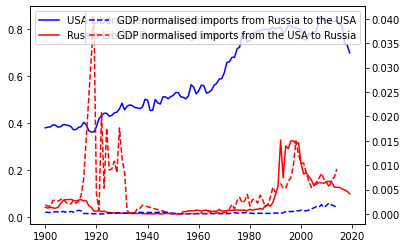

In [ ]:
ctry_gdp_trade = {}
usa_gdp = tradhist_gdppop[(tradhist_gdppop['iso'] == 'USA') & (tradhist_gdppop['year'] >= 1900)][['year', 'GDP']].sort_values(by=['year'])
ctry_gdp_trade['USA'] = pd.merge(usa_gdp, ctry_trade['USA'], how='inner')
rus_gdp = tradhist_gdppop[((tradhist_gdppop['iso'] == 'RUS') | (tradhist_gdppop['iso'] == 'USSR')) & (tradhist_gdppop['year'] >= 1900)][['year', 'GDP']].sort_values(by=['year'])
ctry_gdp_trade['RUS'] = pd.merge(rus_gdp, ctry_trade['RUS'], how='inner')

# plot the data
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(ctry_demind["USA"].values[:, 0], ctry_demind["USA"].values[:, 1], 'b-', label="USA Liberal Democracy Index")
ax2.plot(ctry_gdp_trade["USA"][['year']].values[:, 0], ctry_gdp_trade["USA"][['FLOW']].values[:, 0] / ctry_gdp_trade["USA"][['GDP']].values[:, 0], 'b--', label="GDP normalised imports from Russia to the USA")
ax1.plot(ctry_demind["RUS"].values[:, 0], ctry_demind["RUS"].values[:, 1], 'r-', label="Russia Liberal Democracy Index")
ax2.plot(ctry_gdp_trade["RUS"][['year']].values[:, 0], ctry_gdp_trade["RUS"][['FLOW']].values[:, 0] / ctry_gdp_trade["RUS"][['GDP']].values[:, 0], 'r--', label="GDP normalised imports from the USA to Russia")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
plt.show()

This normalised data does seems to show a significant correlation between Russian imports of American goods with democratization.

We now need to find a way of linking the two datasets. The trade history dataset uses the ISO country codes. However the V-Dem dataset seems to have its own country numbering system, and the three letter shortened name isn't specified in the reference manual to be the ISO name. Lets look at the union of the country codes for the two datasets and the country codes which are unique to each dataset.

In [ ]:
vdem_country_codes = set(vdem_nodes['country_text_id'].unique())
tradhist_country_codes = set(tradhist_timevar['iso_o'].unique())
shared_codes = vdem_country_codes & tradhist_country_codes
vdem_unique_codes = vdem_country_codes - shared_codes
tradhist_unique_codes = tradhist_country_codes - shared_codes

def print_set(code_set, per_line = 20):
    code_ordered = sorted(list(code_set))
    for i in range(0, len(code_ordered), per_line):
        print(code_ordered[i:i + per_line])

print("Shared Country Codes:")
print_set(shared_codes)
print()
print("VDem Only Country Codes:")
print_set(vdem_unique_codes)
print()
print("TradHist Only Country Codes:")
print_set(tradhist_unique_codes)
print()


Shared Country Codes:
['AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA']
['BRB', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU']
['DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB']
['GNQ', 'GRC', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN']
['KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX']
['MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN']
['PAK', 'PAN', 'PER', 'PHL', 'PNG', 'POL', 'PRK', 'PRT', 'PRY', 'QAT', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV'

The major difference seems to be that the V-Dem dataset uses a consistent code for the varying regimes of a 'country', compared to the CEPII dataset using for example USSR for the Soviet Union instead of continuing to use RUS. We need to find if there are any other examples of this and create a mapping system. We will not include trade participants from the trade dataset that are current subareas of sovereignties, as they provide no additional data to correlate with nation democratization given that their owning sovereignty is already featured in the dataset. However we will lump together formerly separate sovereignties that have no additional coding in the V-Dem dataset, such as Prince Edward Island and Canada.

For former countries that cover the land of multiple modern countries, we will associate the trade of those countries at the time with all of the modern countries in their former land area.

In [ ]:
def get_mapping():    
    mapped_codes = [['RUS', 'USSR'], ['YEM', 'ADEN'], ['CAF', 'AOFAEF', 'FRAAEF'], ['TCD', 'AOFAEF', 'FRAAEF'], ['COD', 'AOFAEF', 'FRAAEF'], ['HRV', 'AUTHUN', 'YUG'], ['SVK', 'CZSK', 'AUTHUN'], 
                ['SVN', 'AUTHUN', 'YUG'], ['UKR', 'AUTHUN', 'USSR'], ['ALB', 'AUTHUN'], ['BIH', 'AUTHUN', 'YUG'], ['MNE', 'AUTHUN', 'YUG'], ['CAN', 'CANPRINCED', 'CANQBCONT', 'NFLD'], 
                ['CZE', 'CZSK', 'AUTHUN'], ['DDR', 'EDEU'], ['MYS', 'FEDMYS', 'UNFEDMYS', 'GBRBORNEO'], ['BFA', 'FRAAOF'], ['GNQ', 'FRAAOF'], ['LUX', 'ZOLL'], 
                ['ZZB', 'ZANZ', 'GBRAFRI'], ['ZAF', 'ZAFTRA', 'ZAFORA', 'ZAFNAT', 'ZAPCAF', 'GBRAFRI'], ['MKD', 'YUG'], ['SRB', 'YUG'], ['POL', 'USSR'], ['COM', 'MYT'], ['ROM', 'ROU'], 
                ['MWI', 'RHOD', 'GBRAFRI'], ['ZMB', 'RHOD', 'GBRAFRI'], ['ZWE', 'RHOD', 'GBRAFRI'], ['SGP', 'STRAITS'], ['DEU', 'WDEU'], ['SML', 'GBRSOM', 'ITASOM'], ['GBR', 'ULSTER'], 
                ['RWA', 'RWABDI'], ['SOM', 'ITASOM'], ['MAR', 'MARESP'], ['FRA', 'OLDENB'], ['DNK', 'SCHLES'], ['LBN', 'SYRLBN', 'OTTO'], ['SYR', 'SYRLBN'], ['CYP', 'OTTO', 'GBRMEDI'], 
                ['TUR', 'OTTO'], ['STP', 'PRTAFRI'], ['AGO', 'PRTAFRI'], ['MOZ', 'PRTAFRI'], ['GNB', 'PRTWAFRI'], ['KHM', 'INDOCHI'], ['LAO', 'INDOCHI'], ['VNM', 'INDOCHI'], 
                ['ERI', 'ITAEAFRI', 'GBRAFRI'], ['TTO', 'GBRWINDIES'], ['SLE', 'GBRWAFRI'], ['GMB', 'GBRWAFRI'], ['TGO', 'GBRWAFRI'], ['EGY', 'OTTO'],
                ['PNG', 'GBRPAPUA'], ['MLT', 'GBRMEDI'], ['BGD', 'GBRIND'], ['BTN', 'GBRIND'], ['IND', 'GBRIND'], ['MDV', 'GBRIND'], ['NPL', 'GBRIND'], ['PAK', 'GBRIND'], 
                ['LKA', 'GBRIND'], ['CMR', 'GBRAFRI', 'FRAAFRI'], ['KEN', 'GBRAFRI'], ['SYC', 'GBRAFRI'], ['SDN', 'GBRAFRI'], ['UGA', 'GBRAFRI'], ['LSO', 'GBRAFRI'], 
                ['SWZ', 'GBRAFRI']]

    # validate my matches
    code_count = {}
    for codes in mapped_codes:
        matched_to_vdem = 0
        for code in codes:
            if len(code) == 3:
                if code in vdem_country_codes:
                    if code in code_count:
                        code_count[code] += 1
                    else:
                        code_count[code] = 1
                    matched_to_vdem += 1

        if matched_to_vdem == 0:
            raise ValueError("{} country code set matched to no VDem node".format(codes))
        elif matched_to_vdem > 1:
            raise ValueError("{} country code set matched to more than one VDem node".format(codes))

        if codes[0] not in vdem_country_codes:
            raise ValueError("VDem code should be first in list.")

    for code in code_count:
        if code_count[code] != 1:
            raise ValueError("VDem code {} matched to more than one country code set".format(code))

    for code in shared_codes:
        if code not in code_count:
            mapped_codes.append([code])

mapped_codes = get_mapping()

print_set(mapped_codes, 10)

NameError: ignored

Now that we have a mapping between the two datasets we can start putting them together. We will only be using data from 1900 to 2014, as before 1900 the VDem dataset is noted to be much less accurate, and trade data is increasingly absent for smaller nations. 

This is where we will first use our graph learning library of choice, PyTorch Geometric. PyTorch Geometric provides a base class with which to structure the compilation of a dataset.

In [ ]:
!pip install torch==1.5.0
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.4
    Uninstalling torch-scatter-2.0.4:
      Successfully uninstalled torch-scatter-2.0.4


Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.4
    Uninstalling torch-sparse-0.6.4:
      Successfully uninstalled torch-sparse-0.6.4


Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_cluster-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-cluster 1.5.4
    Uninstalling torch-cluster-1.5.4:
      Successfully uninstalled torch-cluster-1.5.4


Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_spline_conv-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-spline-conv 1.2.0
    Uninstalling torch-spline-conv-1.2.0:
      Successfully uninstalled torch-spline-conv-1.2.0


In [ ]:
import torch
import torch_geometric.data as geo_data

ModuleNotFoundError: ignored

We will initially create a simple model trying to predict next year's democracy indicators from this year's democracy indicators, alongside trade and other geopolitical data. This has the disadvantage compared to a more traditional RNN of not having long term memory, but it will create a good baseline.

In [ ]:
def create_mapping_idx_lookup(mapping):
    lookup = {}
    for idx, country in mapping:
        for code in country:
            lookup[code] = idx

    return lookup

In [ ]:
class TradeDemoYearByYearDataset(geo_data.InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(TradeDemoDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

        data_path = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization', 'dataset')
        self.raw_dir = data_path
        self.processed_dir = data_path

        self.year_start = 1900
        self.year_end = 2015

        self.norm_stats = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization', 'dataset')

    @property
    def raw_file_names(self):
        files = []
        # vdem dataset
        files.append("V-Dem-CY-Core-v10.csv")
        # gdp and population data
        files.append("TRADHIST_GDP_POP.xlsx")
        # time invariant bilateral data such as distance, common language
        files.append("TRADHIST_GRAVITY_BILATERAL_TIME_INVARIANT.xlsx")
        # time variant non trade bilateral data such as colony status
        for idx in range(1, 4):
            files.append("TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))
        # historical bilateral trade and tariff data
        for idx in range(1, 4):
            files.append("TRADHIST_BITRADE_BITARIFF_{}.xlsx".format(idx))

        return files

    @property
    def processed_file_names(self):
        return ['traddem.pt']

    def process(self):
        # Read data into Data object.
        vdem_nodes = pd.read_csv(os.path.join(self.raw_dir, "V-Dem-CY-Core-v10.csv"))

        tradhist_gdppop = pd.read_excel(os.path.join(self.raw_dir, "TRADHIST_GDP_POP.xlsx"))

        tradhist_timeinvar = pd.read_excel(os.path.join(self.raw_dir, "TRADHIST_GRAVITY_BILATERAL_TIME_INVARIANT.xlsx"))

        tradhist_timevar_frames = []
        for idx in range(1, 4):
            tradhist_timevar_frames.append(pd.read_excel(os.path.join(self.raw_dir, "TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))))
        tradhist_timevar = pd.concat(tradhist_timevar_frames)

        tradhist_bitrade_frames = []
        for idx in range(1, 4):
            tradhist_bitrade_frames.append(pd.read_excel(os.path.join(self.raw_dir, "TRADHIST_BITRADE_BITARIFF_{}.xlsx".format(idx))))
        tradhist_bitrade = pd.concat(tradhist_bitrade_frames)

        country_mapping = get_mapping()
        country_idx_lookup = create_mapping_idx_lookup(country_mapping)

        num_countries = len(mapping)
        num_node_features = 2 + 5 # include GDP and population data, and democracy data from last year
        num_node_targets = 5 # 5 main indicators of democracy from the VDem dataset
        num_edge_features = 9 # Trade flow, indicator of zero trade, tariffs, current colony relationship, ever a colony, distance, maritime distance, common language, and shared border

        all_years = []

        for year_idx, year in enumerate(range(self.year_start, self.year_end)):
            year_edge_attr = []
            year_edge_index = []

            node_features = np.zeroes((num_countries, num_node_features))
            node_prior = np.
            node_target = np.zeroes((num_countries, num_node_targets))

            for country_idx, country_codes in enumerate(country_mapping):
                nodes_features[country_idx, :2] = tradhist_gdppop[(tradhist_gdppop['country_text_id'].isin(country_codes)) & (tradhist_gdppop['country_text_id'] == year)]
                                                                                 [['GDP', 'POP']].values
                node_features[country_idx, 2:] = vdem_nodes[(vdem_nodes['country_text_id'] == country_codes[0]) & (vdem_nodes['year'] == year)]
                                                                          [['v2x_polyarchy', 'v2x_libdem', 'v2x_partipdem', 'v2x_delibdem', 'v2x_egaldem']].values
                nodes_target[country_idx, :] = vdem_nodes[(vdem_nodes['country_text_id'] == country_codes[0]) & (vdem_nodes['year'] == year + 1)]
                                                                          [['v2x_polyarchy', 'v2x_libdem', 'v2x_partipdem', 'v2x_delibdem', 'v2x_egaldem']].values
            
                timeinvar = tradhist_timeinvar[(tradhist_timeinvar['iso_d'].isin(country_codes))]
                timevar = tradhist_timevar[(tradhist_timevar['iso_d'].isin(country_codes)) & (tradhist_timevar['year'] == year)]
                bitrade = tradhist_bitrade[(tradhist_bitrade['iso_d'].isin(country_codes)) & (tradhist_bitrade['year'] == year)]

                bilateral = timeinvar.merge(timevar, on=["iso_o"]).merge(bitrade, on=["iso_o"])

                for idx, link in bilateral.iterrows():
                    origin_country_idx = country_idx_lookup[link["iso_o"].value[0]]
                    bilateral_attrs = link[['Dist_coord', 'Evercol', 'Comlang', 'Contig', 'SeaDist_2CST', 'Curcol']].value

                    year_edge_attr.append(bilateral_attrs)
                    year_edge_index.append([origin_country_idx, country_idx])

            year_graph = Data(x=torch.tensor(node_features), y=torch.tensor(node_target), edge_index=torch.tensor(year_edge_index), edge_attr=torch.tensor(year_edge_attr))
            all_years.append(year_graph)

        # get normalization stats
        # for completely unbiased test we should only get training set stats but will pass on that for this
        stacked_x = torch.cat((graph.x for graph in all_years), 0)
        stacked_y = torch.cat((graph.y for graph in all_years), 0)
        stacked_atts = torch.cat((graph.edge_attr for graph in all_years), 0)

        x_mean = torch.mean(stacked_x, 0)
        x_std = torch.std(stacked_x, 0)
        y_mean = torch.mean(stacked_y, 0)
        y_std = torch.std(stacked_y, 0)
        attr_mean = torch.mean(stacked_attrs, 0)
        attr_std = torch.std(stacked_attrs, 0)

        for graph in all_years:
            normed_x = (graph.x - x_mean) / x_std
            normed_y = (graph.y - y_mean) / y_std
            normed_attr = (graph.edge_attr - attr_mean) / attr_std
            graph.x = normed_x
            graph.y = normed_y
            graph.edge_attr = normed_attr

        # save stats for later use
        torch.save({"x_mean": x_mean, "x_std": x_std, "y_mean": y_mean, "y_std": y_std, "attr_mean": attr_mean, "attr_std": attr_std}, self.norm_stats)

        data, slices = self.collate(all_years)
        torch.save((data, slices), self.processed_paths[0])

    def get_norm_stats(self):
        return torch.load(self.norm_stats)

Now that the dataset has been created, we need to shuffle, partition, and load the dataset into batches using the PyTorch Geometric data loader.

In [ ]:

dataset = TradeDemoYearByYearDataset()
dataset.shuffle()

# split into three sets
num_train = int(len(dataset) * 0.8)
num_val = int(len(dataset) * 0.1)
num_test = int(len(dataset) * 0.1)

train_set = dataset[:num_train]
val_set = dataset[num_train:num_train+num_val]
test_set = dataset[-num_test:]

# load into batches
train_loader = geo.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = geo.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = geo.data.DataLoader(test_set, batch_size=32, shuffle=True)

Now we will define a simple graph network model that will predict next years democratization level given a range of variables for this year.

In [ ]:
class RegressionGraphNet(torch.nn.Module):
    def __init__(self, num_node_features, num_outputs):
        super(RegressionGraphNet, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_outputs)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)

        # final activation is relu as this is for regression and the metrics of this dataset are all positive
        return F.relu(x)

We now create an instance of the model and optimizer:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(dataset.num_features)
print(dataset[0].y.size(1))
model = RegressionGraphNet(dataset.num_features, dataset[0].y.size(1))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Define our training and test calls

In [ ]:
def train():
    model.train()

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        label = batch.y
        # good loss for regression problems
        loss = F.smooth_l1_loss(out, label)
        loss.backward()
        loss_all += loss.item()
        optimizer.step()
    return loss_all / num_train

@torch.no_grad()
def test(loader):
    model.eval()
    num_batches = 0

    for batch in loader:
        batch = batch.to(device)
        pred = model(batch)
        label = batch.y
        # good loss for regression problems
        loss = F.smooth_l1_loss(pred, label)
        all_loss += loss
        num_batches += 1
    return all_loss / num_batches


In [ ]:
MAX_EPOCHS = 100
min_val_loss = float("inf")
epochs_since = 0
NUM_NON_DECREASING = 10
for epoch in range(MAX_EPOCH):
    train_loss = train()
    val_loss = test(val_loader)

    print('Epoch: {}, Train Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, train_loss, val_loss))

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        epochs_since = 0

    epochs_since += 1
    if epochs_since > NUM_NON_DECREASING:
        print("Early stopping engaged")
        break


In [ ]:
test_loss = test(test_loader)
print('Final Test Loss: {:.4f}'.format(test_loss))

Draft attempt at a recursive graph network, will come back to later after working on simpler model.

In [ ]:
class RecurGraphNet(torch.nn.Module):
    def __init__(self, node_features, output_size, graph_channels_out, lstm_hidden_size):
        super(RecurGraphNet, self).__init__()
        # graph convolutional layer to create graph representation
        self.conv = GCNConv(node_features, graph_embedding_size)
        # lstm to learn sequential patterns
        self.lstm = torch.nn.LSTM(graph_embedding_size, lstm_hidden_size)

        # initial trainable hidden state for lstm
        self.lstm_h_s = torch.nn.Linear(output_size, lstm_hidden_size)
        self.lstm_c_s = torch.nn.Linear(output_size, lstm_hidden_size)

        # final linear layer to allow full expressivity for regression after tanh activation in lstm
        self.final_linear = torch.nn.Linear()

    def forward(self, input):
        x, initial_state, edge_index, edge_attr = input.x, input.initial_state, input.edge_index, input.edge_attr

        # create graph representation
        graph_collection = []
        for step_idx in range(x.shape[0]):
            graph_step = F.relu(self.conv(x[step_idx], edge_index[step_idx], edge_attr[step_idx]))
            graph_collection.append(graph_step)
        # provide graph representations as sequence to lstm
        graph_series = torch.stack(graph_collection)

        # recurrent stage
        # initial state of lstm is representation of target prior to this sequence
        lstm_output = self.lstm(graph_series, (self.lstm_h_s(initial_state), self.lstm_c_s(initial_state)))

        # final activation is relu as this is for regression and the metrics of this dataset are all positive
        return F.relu(self.final_linear(lstm_output.view(-1, lstm_output.size(2)))

For missing values, we want to provide the model with as little information as possible to avoid it creating any incorrect correlations. In this context, the least information we can give for a missing time point with the lowest information entropy is an average. Therefore once all trade data has been normalised by the aggregate trade for a country, missing values will be filled with an average of all present values.